# Importing Packages

In [304]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from math import sqrt
from sklearn.metrics import mean_squared_error
from arch.unitroot import PhillipsPerron as pp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

# 1. Importing  and Filtering the Data

## 1.1 Training Data

In [305]:
dt_parse = lambda dates: dt.strptime(dates, '%Y-%m-%d %H:%M:%S')

data = pd.read_csv('data/transformed/2000_2021_Brazilian_North_Region_hourly_MWmed_hydroelectric_power_series.csv',
                   header=0, names=['index','value', 'date'], parse_dates=True, index_col='index', date_parser=dt_parse)
data['value'] = data['value'].astype(float)
data['date'] = data['date'].astype('datetime64')
data = data[data['value'] > 0.0]
data['year']  = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day']   = data['date'].dt.day
data['hour'] = data['date'].dt.hour
data['weekday'] = data['date'].dt.weekday
data.head()

,value,date,year,month,day,hour,weekday
index,,,,,,,
2000-01-01 00:00:00,2422.5,2000-01-01 00:00:00,2000,1,1,0,5
2000-01-01 01:00:00,2769.3,2000-01-01 01:00:00,2000,1,1,1,5
2000-01-01 02:00:00,3124.7,2000-01-01 02:00:00,2000,1,1,2,5
2000-01-01 03:00:00,3154.6,2000-01-01 03:00:00,2000,1,1,3,5
2000-01-01 04:00:00,3121.8,2000-01-01 04:00:00,2000,1,1,4,5


# 2. Data Exploration Analysis

## 2.1 Value over times

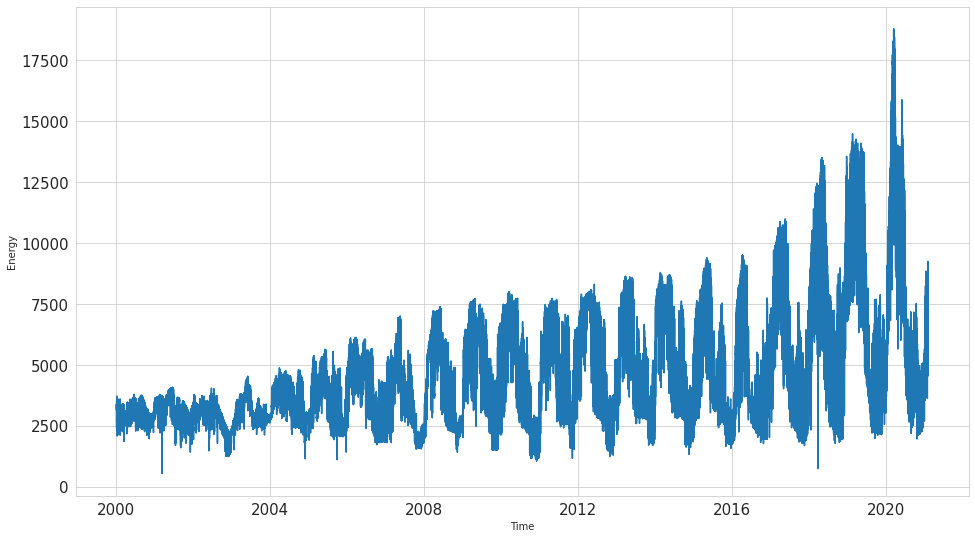

In [306]:
plt.rcParams["figure.figsize"] = [16,9]
plt.ylabel('Energy')
plt.xlabel('Time')
plt.plot(data['value'])

## 2.2 Test Data with one hundred first values

In [307]:
describe = data['value'].describe()
mode = data['value'].mode()
variant = data['value'].var()
print(f"Variant: {variant}")
print(f"Mode: {mode}")
for key in describe.keys():
    print(f"{key}: {describe[key]}")

Variant: 6149418.358946173
Mode: 0    3045.0
dtype: float64
count: 184782.0
mean: 4619.7879699835485
std: 2479.802080599614
min: 539.5
25%: 2921.5
50%: 3694.1499999999996
75%: 5896.09225
max: 18793.893


## 2.3 Test Data with all values with another form

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


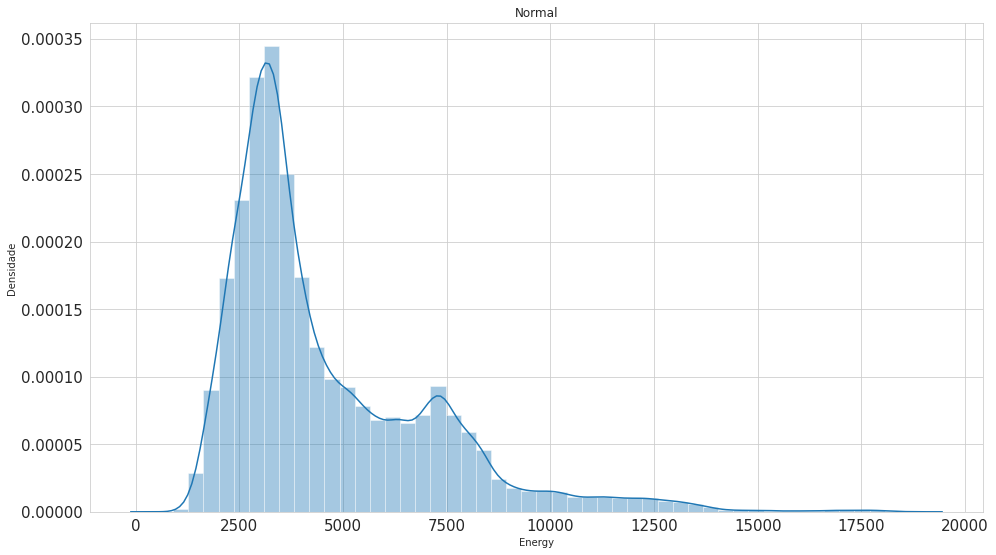

In [308]:
ax = sns.distplot(data['value'], kde=True)
ax.set(xlabel= 'Energy', ylabel='Densidade', title='Normal')
plt.show()

## 2.4 Line

Permite ver dados mes a mes.

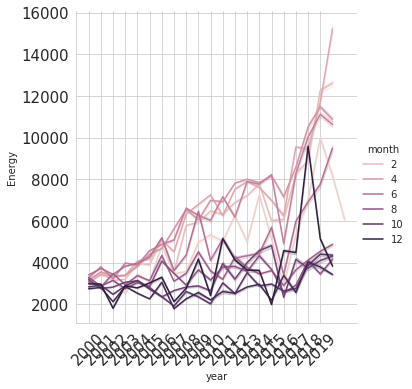

In [309]:
sns.relplot(data=data, x="year", y="value", hue="month", kind='line')
plt.ylabel('Energy')
plt.xticks(np.arange(2000, 2020, 1), rotation=45)
plt.show()
# data.hist(figsize=(15,12), column='value', by='month', bins=25)

## 2.5 Box-plot

Permiter ver as medianas e os quartis. Importante para ver como os dados estão distribuidos por ano.

Text(0, 0.5, 'Energy')

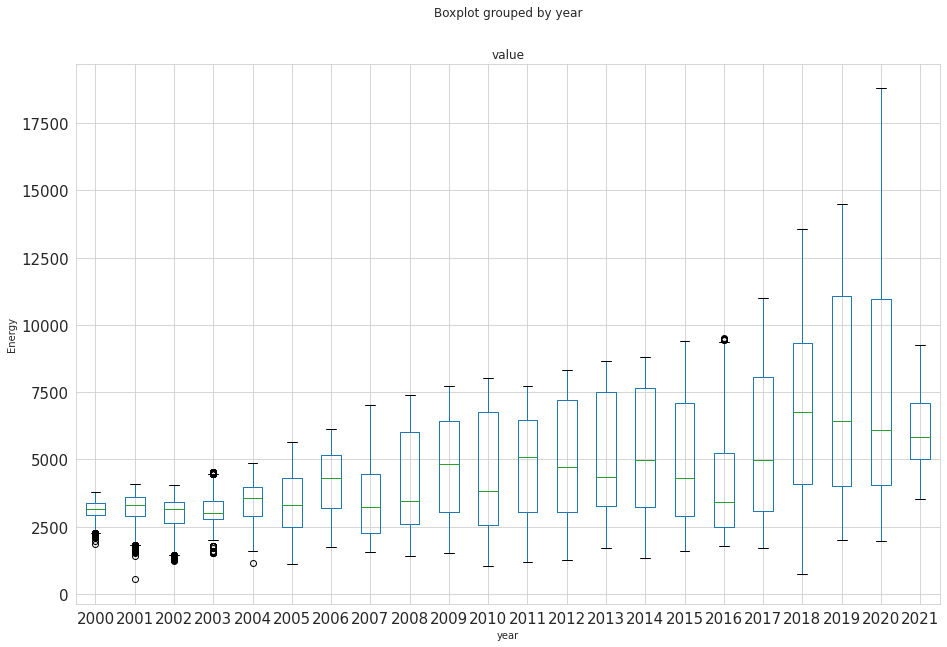

In [310]:
data.boxplot(figsize=(15,10), by='year', column=['value'])
plt.ylabel('Energy')

# 3. Transformation

## 3.1 Box-Cox transformation

A transformação de Box-Cox faz uma curva ficar normalmente distribuida, assim permitindo o usuario a fazer uma serie de testes que só podem ser usados em séries distribuidas assim.

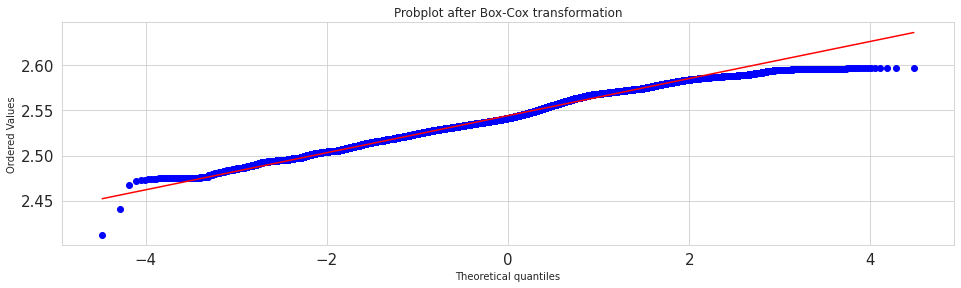

In [311]:
fig = plt.figure()
# ax1 = fig.add_subplot(211)
x = stats.loggamma.rvs(5, size=500) + 5
# prob = stats.probplot(data['value'], dist=stats.norm, plot=ax1)
# ax1.set_xlabel('')
# ax1.set_title('Probplot against normal distribution')
ax2 = fig.add_subplot(212)
xt, _ = stats.boxcox(data['value'])
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
plt.show()

## 3.2 Log transformation

A transformação Log diminui o vies dos dados.

None


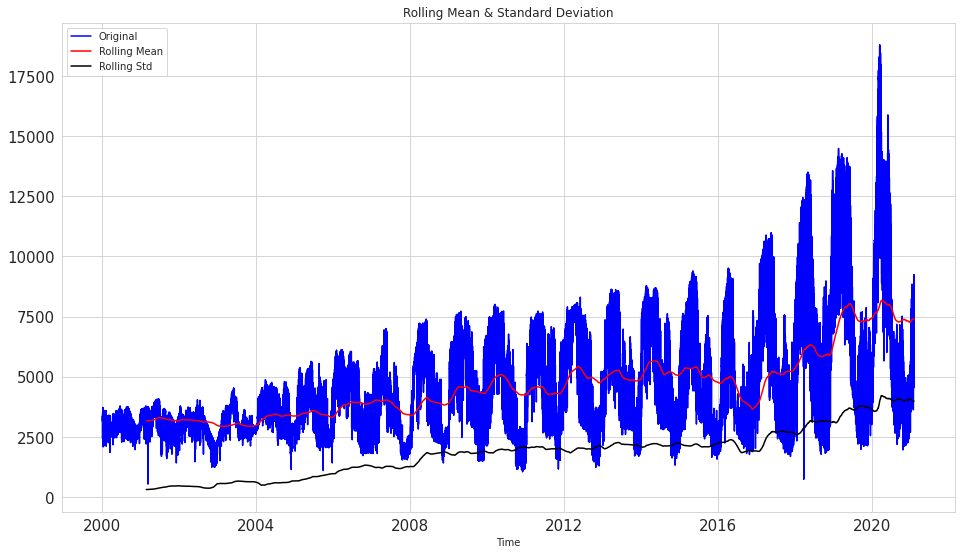

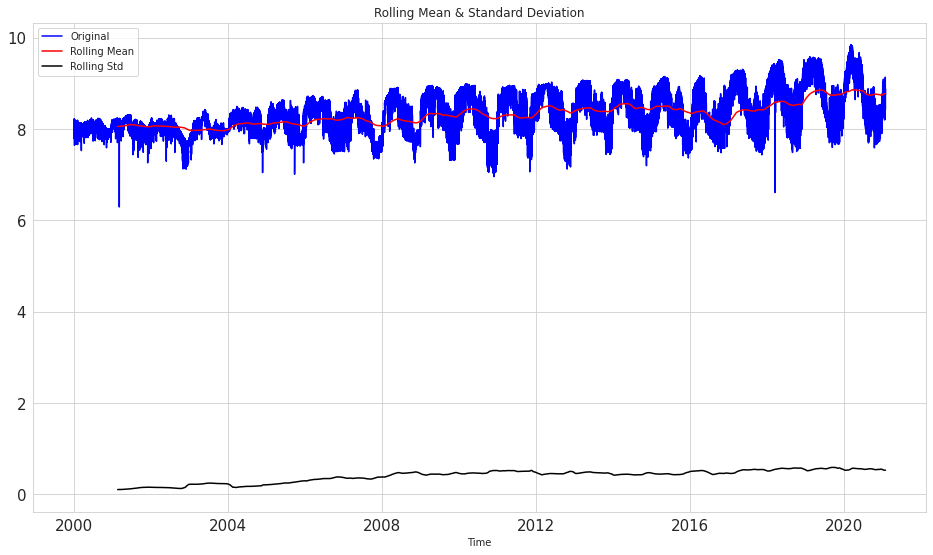

In [312]:
v_log = np.log(data['value'])
data = data.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
value = data['value']
print(pd.infer_freq(value.index))

def test_stationarity(timeseries, window_size=10000):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window_size).mean()
    rolstd  = timeseries.rolling(window_size).std()

    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xlabel('Time')
    plt.show(block=False)

test_stationarity(data['value'])

test_stationarity(v_log)
v_log.to_csv('data/exported/transformed_log.csv')

# 4. Decomposition

Divide serie temporal em tendencia, sazonalidade e aleatoriedade.

- Tendencia: Permite checar se serie temporal tem um padrão de aumento/diminuição dos valores com o tempo;
- Sazonalidade: Representa a variação recorrente(anual, mensal, semanal, ...);

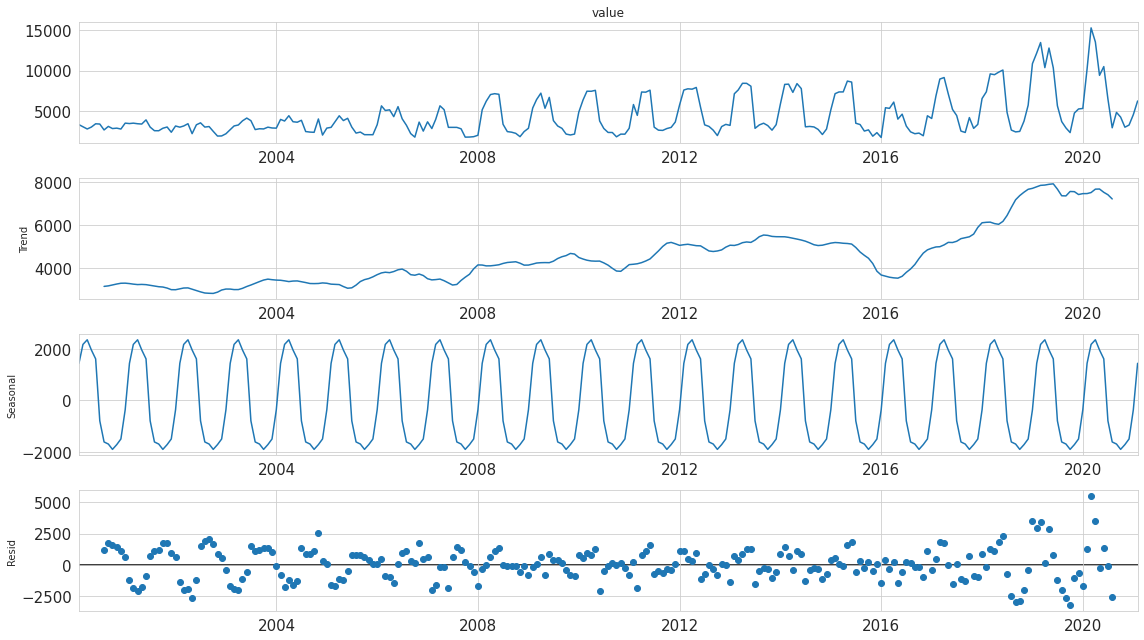

In [313]:
data.sort_index(inplace=True)
data.drop(['date', 'year', 'month', 'day', 'hour', 'weekday'],inplace=True,axis=1)

decomposition = sm.tsa.seasonal_decompose(data.value.asfreq('m'), model='additive')
plt.rcParams["figure.figsize"] = [16,9]
fig = decomposition.plot()

# 5. Tests

Finalidade: Determinar estacionariedade de uma série temporal.

## 5.1 Test KPPS

In [314]:
series = data['value']
statistic, p, lags, values = sm.tsa.kpss(series)
print(f"Test statistic: {statistic}")
print(f"P Value: {p}")
print(f"Lags: {lags}")
for key in values.keys():
    print(f"{key}: {values[key]}")

Test statistic: 55.819347135610435
P Value: 0.01
Lags: 79
10%: 0.347
5%: 0.463
2.5%: 0.574
1%: 0.739


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


## 5.2 Test PP

In [315]:
pp(series)

Test Statistic,-19.055
P-value,0.000
Lags,79


## 5.3 Test Fuller

In [316]:
statistic, p, lags, dont_know, values, test = sm.tsa.adfuller(series.head(10000))
print(f"Test statistic: {statistic}")
print(f"P Value: {p} ???")
print(f"Lags: {lags}")
for key in values.keys():
    print(f"{key}: {values[key]}")

Test statistic: -6.5849014467475175
P Value: 7.356345420225857e-09 ???
Lags: 33
1%: -3.431006330034765
5%: -2.861830058724424
10%: -2.566924393122448


# 6. Persistence

O que o modelo de persistencia faz?

O modelo de persistencia fala que o valor de n é igual ao de n + 1.

In [317]:
split_date = '1/1/2019 12:00:00 AM'
test  = data[split_date : ]
train = data[ : split_date]
show = data['1/1/2018 12:00:00 AM' : split_date]

test.head()

,value
index,
2019-01-01 00:00:00,7297.073
2019-01-01 01:00:00,6900.449
2019-01-01 02:00:00,6869.606
2019-01-01 03:00:00,6856.405
2019-01-01 04:00:00,6853.338


#### Concatenate train and test series to plotting

In [318]:
train = train['value']
test = test['value']
series = pd.concat([show['value'], test], axis=0)
series

index
2018-01-01 00:00:00    4157.938
2018-01-01 01:00:00    4002.385
2018-01-01 02:00:00    3999.003
2018-01-01 03:00:00    3998.635
2018-01-01 04:00:00    4000.610
                         ...   
2021-01-30 20:00:00    7217.682
2021-01-30 21:00:00    7187.145
2021-01-30 22:00:00    6658.727
2021-01-30 23:00:00    6529.498
2021-01-31 00:00:00    6279.152
Name: value, Length: 27025, dtype: float64

#### Prepare data

O resultado do modelo de persistencia da a baseline. Basicamente permite comparar outros modelos com o seu resultado para assim checar sua eficiencia.

Vantangens do modelo de persistencia:
- Simples
- Rapido
- Facil de replicar

In [319]:
def persistence(last_ob, n_steps):
    return [last_ob for i in range(n_steps)]


test = test.values
series = series.values
train = [x for x in train]

# Number of multi-step
n_steps = 24

# Store multi-step forecasts
forecasts = list()

# Number of multi-step forecasts
n_forecasts = len(test) - n_steps + 1

# Walk-forward validation
for i in range(n_forecasts):
    # Make a multi-step forecast
    last_ob = train[-1]
    yhat = persistence(last_ob, n_steps)

    # Store the multi-step forecast
    forecasts.append(yhat)

    # Add actual observation to train for the next loop
    obs = test[i]
    train.append(obs)

print(train[-10:])
print(forecasts[-10:])

[8566.823, 8271.562, 8012.252, 8290.312, 8289.579, 8273.642, 7498.538, 6300.131, 5519.645, 5425.253]
[[9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427, 9237.427], [8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823, 8566.823], [8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562, 8271.562], [8012.252, 8012.252, 8012.252, 8012.252, 8012.252, 8012.252, 8012.252, 8012.252, 8012.252, 8012.252, 8012.252, 8012.252, 8012.252, 8012.252, 8012.252, 8012.252, 8012.252, 8

#### Evaluate the forecasts

In [320]:
# Evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_steps):
    for i in range(n_steps):
        # Picking the values from multi-step forecasts
        ypred_ts = [forecast[i] for forecast in forecasts]

        # Sliding window on test series
        ytrue_ts = test[i:len(ypred_ts)+i]
        print(f"t+{(i+1)} RMSE: {sqrt(mean_squared_error(ytrue_ts, ypred_ts))}")


evaluate_forecasts(test, forecasts, n_steps)

t+1 RMSE: 409.6679707744369
t+2 RMSE: 702.4252573745656
t+3 RMSE: 930.8436093712165
t+4 RMSE: 1123.278275355191
t+5 RMSE: 1286.3788091984102
t+6 RMSE: 1424.4259975880425
t+7 RMSE: 1538.5519571245466
t+8 RMSE: 1628.6314821337453
t+9 RMSE: 1696.2535587357004
t+10 RMSE: 1744.4603870372187
t+11 RMSE: 1777.5107859972222
t+12 RMSE: 1796.7560491423558
t+13 RMSE: 1800.065064700899
t+14 RMSE: 1792.0138367423424
t+15 RMSE: 1772.0411287271495
t+16 RMSE: 1736.9171166598487
t+17 RMSE: 1685.2838250478333
t+18 RMSE: 1617.0319445060563
t+19 RMSE: 1535.8141285704728
t+20 RMSE: 1447.0591545233078
t+21 RMSE: 1356.3109858244673
t+22 RMSE: 1272.7963562423045
t+23 RMSE: 1206.1293188346324
t+24 RMSE: 1182.6876348271585


## 6.1 Plot the forecasts in multi steps

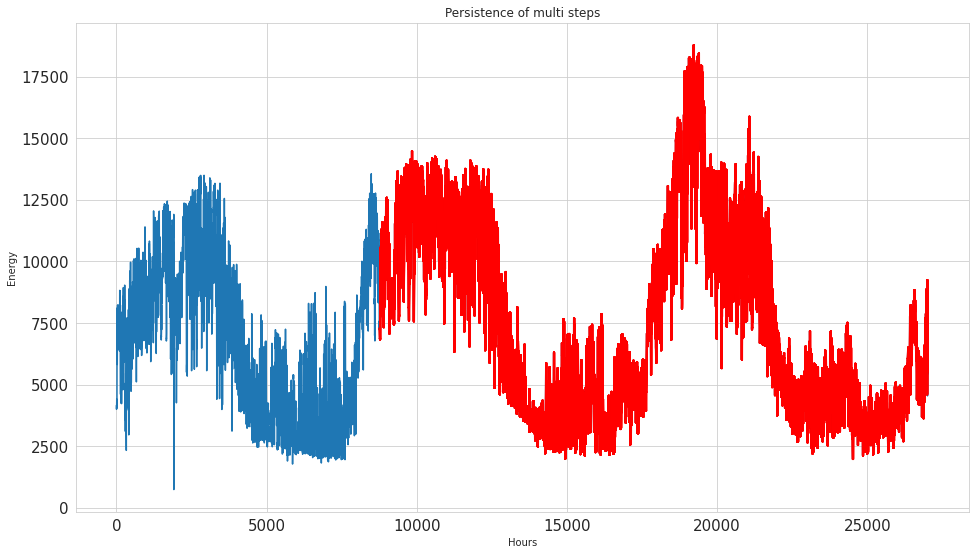

In [321]:
# Plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, test):
    # Plot the entire dataset in blue
    x_points = []
    y_points = []

    # Plot the forecasts in red
    for i in range(len(forecasts)):
        # Start offset for x-axis
        off_s = len(series) - len(test) + i - 1

        # End offset for x-axis
        off_e = off_s + len(forecasts[i]) + 1

        # Indexes of x-axis for multi-step forecasts
        xaxis = [x for x in range(off_s, off_e)]
        x_points.append(xaxis)
        # xaxis = np.array(xaxis)

        # Values of muti-step fotecasts
        yaxis = [series[off_s]] + forecasts[i]
        y_points.append(yaxis)
        # yaxis = np.array(yaxis)

        # sns.lineplot(data=xaxis, color='blue')
        # sns.lineplot(data=yaxis, color='red')

    # Show the final plot
    plt.plot(series)
    plt.plot(x_points, y_points, color='red')
    plt.ylabel('Energy')
    plt.xlabel('Hours')
    plt.title('Persistence of multi steps')
    plt.show()


plot_forecasts(series, forecasts, test)

## 6.2 Persistence with one step

In [322]:
predictions = list()
for i in range(len(test)):
    # Predict
    yhat = train[-1]
    # Store forecast in list of predictions
    predictions.append(yhat)
    # Add actual observation to train for the next loop
    obs = test[i]
    train.append(obs)
    # print(f">Predicted={yhat}, Expected={obs}")

#### Report performance

In [323]:
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 409.812


#### Plot predicted vs expected values

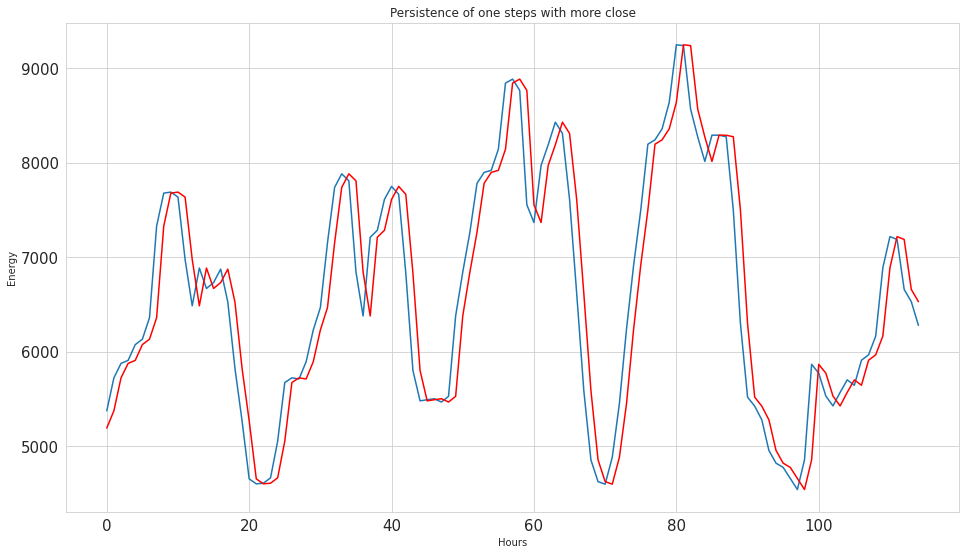

In [324]:
plt.plot(test[18150:])
plt.plot(predictions[18150:], color='red')
plt.ylabel('Energy')
plt.xlabel('Hours')
plt.title('Persistence of one steps with more close')
plt.show()

# 7. Exponential smoothing


## 7.1 Simple Exponential smoothing

Text(0.5, 1.0, 'Simples Exponential smoothing')

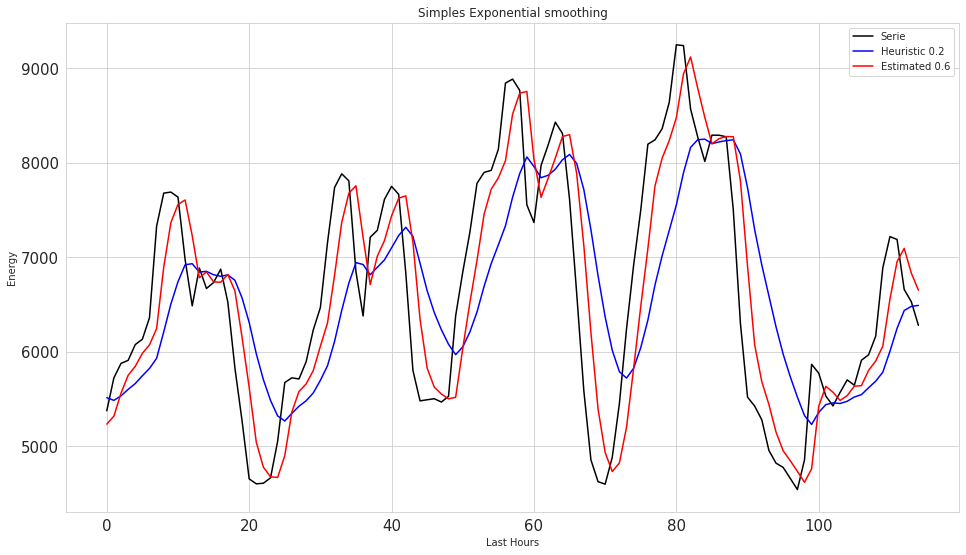

In [325]:
heuristic = SimpleExpSmoothing(test, initialization_method="heuristic").fit(smoothing_level=0.2,optimized=False)
estimated = SimpleExpSmoothing(test, initialization_method="estimated").fit(smoothing_level=0.6,optimized=False)

plt.plot(test[18150:], color='black')
plt.plot(heuristic.fittedvalues[18150:], color='blue')
plt.plot(estimated.fittedvalues[18150:], color='red')
plt.legend(['Serie', 'Heuristic 0.2', 'Estimated 0.6'])
plt.ylabel('Energy')
plt.xlabel('Last Hours')
plt.title('Simples Exponential smoothing')

## 7.2 Holt's Method

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Text(0.5, 1.0, "Holt's method")

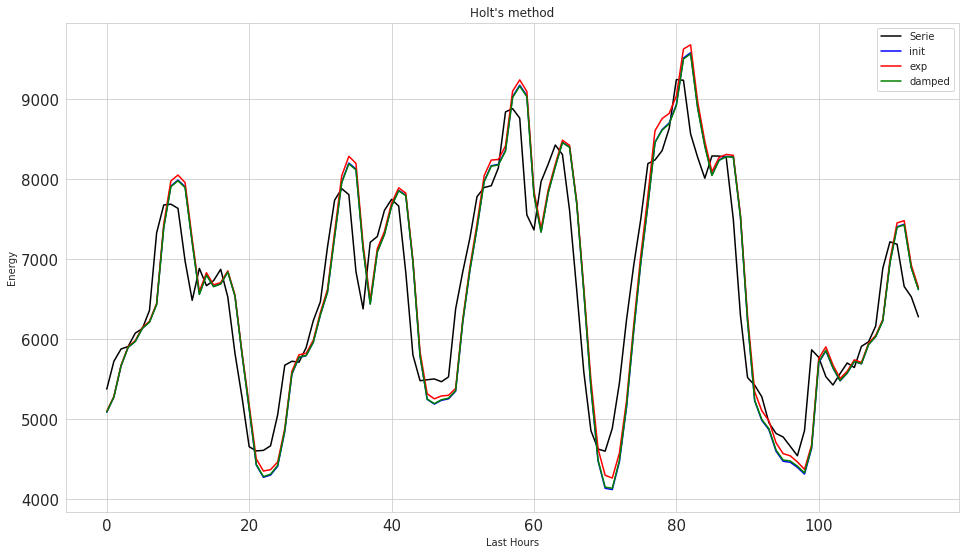

In [326]:
initialization = Holt(test, initialization_method="estimated").fit(smoothing_level=0.8, smoothing_trend=0.2, optimized=False)
exponential = Holt(test, exponential=True, initialization_method="estimated").fit(smoothing_level=0.8, smoothing_trend=0.2, optimized=False)
damped = Holt(test, damped_trend=True, initialization_method="estimated").fit(smoothing_level=0.8, smoothing_trend=0.2)

plt.plot(test[18150:], color='black')
plt.plot(initialization.fittedvalues[18150:], color='blue')
plt.plot(exponential.fittedvalues[18150:], color='red')
plt.plot(damped.fittedvalues[18150:], color='green')
plt.legend(['Serie', 'init', 'exp', 'damped'])
plt.ylabel('Energy')
plt.xlabel('Last Hours')
plt.title("Holt's method")

## 7.3 Holt's Winter

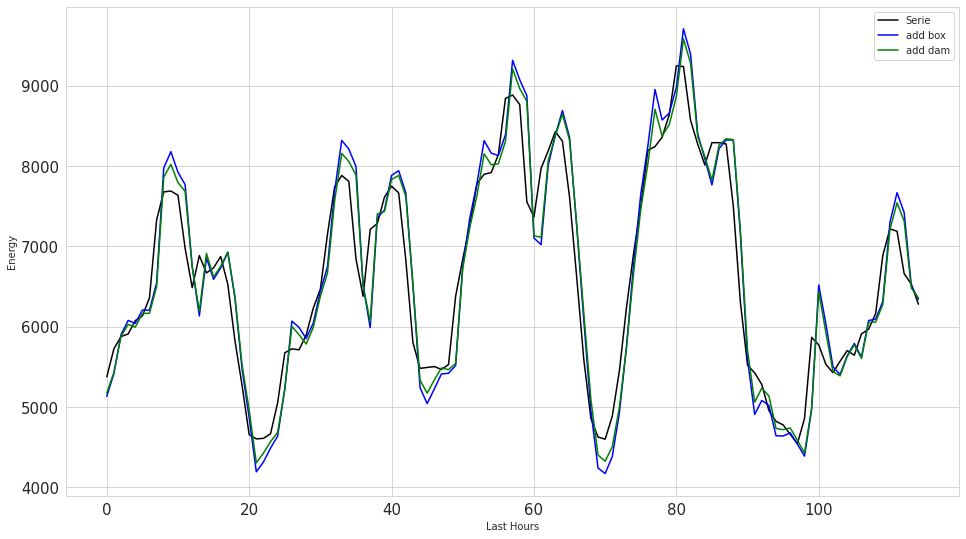

In [327]:
estimated_add_box = ExponentialSmoothing(test, seasonal_periods=4, trend='add', seasonal='add', use_boxcox=True, initialization_method="estimated").fit()
estimated_mul_box = ExponentialSmoothing(test, seasonal_periods=4, trend='add', seasonal='mul', use_boxcox=True, initialization_method="estimated").fit()
estimated_add_dam = ExponentialSmoothing(test, seasonal_periods=4, trend='add', seasonal='add', damped_trend=True, use_boxcox=True, initialization_method="estimated").fit()
estimated_mul_dam = ExponentialSmoothing(test, seasonal_periods=4, trend='add', seasonal='mul', damped_trend=True, use_boxcox=True, initialization_method="estimated").fit()
# results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
# params = ['smoothing_level', 'smoothing_trend', 'damping_trend', 'smoothing_seasonal', 'initial_level', 'initial_trend']
# results["Additive"]       = [fit1.params[p] for p in params] + [fit1.sse]
# results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse]
# results["Additive Dam"]   = [fit3.params[p] for p in params] + [fit3.sse]
# results["Multiplica Dam"] = [fit4.params[p] for p in params] + [fit4.sse]

# ax = test.plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Holt-Winters' multiplicative method" )
# ax.set_ylabel("International visitor night in Australia (millions)")
# ax.set_xlabel("Year")
# fit1.fittedvalues.plot(ax=ax, style='--', color='red')
# fit2.fittedvalues.plot(ax=ax, style='--', color='green')

# fit1.forecast(8).rename('Holt-Winters (add-add-seasonal)').plot(ax=ax, style='--', marker='o', color='red', legend=True)
# fit2.forecast(8).rename('Holt-Winters (add-mul-seasonal)').plot(ax=ax, style='--', marker='o', color='green', legend=True)

plt.plot(test[18150:], color='black')
plt.plot(estimated_add_box.fittedvalues[18150:], color='blue') #eguals to estimated_mul_box
# plt.plot(estimated_mul_box.fittedvalues[18150:], color='red')
plt.plot(estimated_add_dam.fittedvalues[18150:], color='green') #eguals to estimated_mul_dam
# plt.plot(estimated_mul_dam.fittedvalues[18150:], color='orange')
plt.legend(['Serie', 'add box', 'add dam', 'mul dam'])
plt.ylabel('Energy')
plt.xlabel('Last Hours')
plt.show()